In [1]:
#
#   mnist_ae2.py   date. 7/4/2016
#   
#   Autoencoder tutorial code - trial of convolutional AE
#
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
from my_nn_lib import Convolution2D, MaxPooling2D
from my_nn_lib import FullConnected, ReadOutLayer
%matplotlib inline

# Up-sampling 2-D Layer (deconvolutoinal Layer)
class Conv2Dtranspose(object):
    '''
      constructor's args:
          input      : input image (2D matrix)
          output_siz : output image size
          in_ch      : number of incoming image channel
          out_ch     : number of outgoing image channel
          patch_siz  : filter(patch) size
    '''
    def __init__(self, input, output_siz, in_ch, out_ch, patch_siz, activation='relu'):
        self.input = input      
        self.rows = output_siz[0]
        self.cols = output_siz[1]
        self.out_ch = out_ch
        self.activation = activation
        
        wshape = [patch_siz[0], patch_siz[1], out_ch, in_ch]    # note the arguments order
        
        w_cvt = tf.Variable(tf.truncated_normal(wshape, stddev=0.1), 
                            trainable=True)
        b_cvt = tf.Variable(tf.constant(0.1, shape=[out_ch]), 
                            trainable=True)
        self.batsiz = tf.shape(input)[0]
        self.w = w_cvt
        self.b = b_cvt
        self.params = [self.w, self.b]
        
    def output(self):
        shape4D = [self.batsiz, self.rows, self.cols, self.out_ch]      
        linout = tf.nn.conv2d_transpose(self.input, self.w, output_shape=shape4D,
                            strides=[1, 2, 2, 1], padding='SAME') + self.b
        if self.activation == 'relu':
            self.output = tf.nn.relu(linout)
        elif self.activation == 'sigmoid':
            self.output = tf.sigmoid(linout)
        else:
            self.output = linout
        
        return self.output

# Create the model
def model(X, w_e, b_e, w_d, b_d):
    encoded = tf.sigmoid(tf.matmul(X, w_e) + b_e)
    decoded = tf.sigmoid(tf.matmul(encoded, w_d) + b_d)
    
    return encoded, decoded

def mk_nn_model(x, sentp=None, y=None, bs=8):
    # Encoding phase
    x_image = x #tf.reshape(x, [-1, 64, 64, 1])
    if y==None:
        y=x
        
    conv00 = Convolution2D(x_image, (64, 64), 3, 4, 
                          (5, 5), activation='relu')
    conv00_out = conv00.output()
    
    conv0 = Convolution2D(conv00_out, (64, 64), 4, 4, 
                          (3, 3), activation='relu')
    conv0_out = conv0.output()
    
    pool0 = MaxPooling2D(conv0_out)
    pool0_out = pool0.output()
    
    conv1 = Convolution2D(pool0_out, (32, 32), 4, 8, 
                          (3, 3), activation='relu')
    conv1_out = conv1.output()
    
    pool1 = MaxPooling2D(conv1_out)
    pool1_out = pool1.output()
    
    conv2 = Convolution2D(pool1_out, (16, 16), 8, 16, 
                          (3, 3), activation='relu')
    conv2_out = conv2.output()
    
    pool2 = MaxPooling2D(conv2_out)
    pool2_out = pool2.output()

    conv3 = Convolution2D(pool2_out, (8, 8), 16, 16, (3, 3), activation='relu')
    conv3_out = conv3.output()

    pool3 = MaxPooling2D(conv3_out)
    pool3_out = pool3.output()
    # at this point the representation is (8, 4, 4) i.e. 128-dimensional
    
    
    flatenned = tf.contrib.layers.flatten(pool3_out)
    if sentp!=None:
        flatenned = tf.concat([flatenned, sentp],1)
    flatenned = tf.layers.dense(flatenned, 128*2, activation=tf.nn.relu)
    flatenned = tf.layers.dense(flatenned, 128*2, activation=tf.nn.relu)
    
    net = tf.reshape(flatenned, [bs, 4, 4, 16])
    
    # Decoding phase
    conv_t1 = Conv2Dtranspose(net, (8, 8), 16, 16,
                         (3, 3), activation='relu')
    conv_t1_out = conv_t1.output()

    conv_t2 = Conv2Dtranspose(conv_t1_out, (16, 16), 16, 8,
                         (3, 3), activation='relu')
    conv_t2_out = conv_t2.output()

    conv_t3 = Conv2Dtranspose(conv_t2_out, (32, 32), 8, 4, 
                         (3, 3), activation='relu')
    conv_t3_out = conv_t3.output()

    conv_t35 = Conv2Dtranspose(conv_t3_out, (64, 64), 4, 4, 
                         (3, 3), activation='relu')
    conv_t35_out = conv_t35.output()

    conv_last = Convolution2D(conv_t35_out, (64, 64), 4, 3, (5, 5),
                         activation='sigmoid')
    decoded = conv_last.output()

#     decoded = tf.reshape(decoded, [-1, 64*64])
    cross_entropy = -1. *y *tf.log(decoded + 1e-30) - (1. - y) *tf.log(1. - decoded + 1e-30)
    loss = tf.reduce_mean(cross_entropy)
       
    return loss, decoded


In [2]:
bs=8
hs=64

x = tf.placeholder(tf.float32, [None, 64, 64, 3])
y = tf.placeholder(tf.float32, [None, 64, 64, 3])
# sentp = tf.placeholder(tf.float32, [None, 10])


loss, decoded = mk_nn_model(x, y=y, sentp=None, bs=bs)
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)


In [3]:
# len(mnist.train.images)

In [4]:
sentences = np.load('sentences_64.npy')
original_imgs = np.load('original_imgs_64.npy')
translated_imgs = np.load('translated_imgs_64.npy')

sentences_float = np.array(sentences, dtype=np.float32)
original_imgs_float = np.array(original_imgs, dtype=np.float32)
translated_imgs_float = np.array(translated_imgs, dtype=np.float32)

In [5]:


# onesar = np.ones((55000, hs, hs, 3))
# onesar[:,hs//2:,hs//2:,0:2] = 0

# onesar = onesar.reshape(55000, hs*hs)
# onesar = mnist.train.images

In [6]:
train_max = 95000

input_img = original_imgs_float[:train_max] #np.array([original_imgs_float[0] for i in range(55000)])
output_img = translated_imgs_float[:train_max]
sent_inp = sentences_float[:train_max]

input_test = original_imgs_float[train_max:]
output_test = translated_imgs_float[train_max:]
sent_test = sentences_float[train_max:]


In [7]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3

sess =  tf.Session()
sess.run(tf.global_variables_initializer())
j=0

In [8]:

print('Training...')
for i in range(300000):
    if j+bs >= len(input_test):
        j=0
    batch_xs = input_img[j:j+bs]
    batch_ys = output_img[j:j+bs]
    batch_sent = sent_inp[j:j+bs]
    train_step.run({x: batch_xs, y: batch_ys}, session=sess)
    if i % 500 == 0:
        train_loss= loss.eval({x: batch_xs, y: batch_ys}, session=sess)
        print('  step, loss = %7d: %6.5f' % (i, train_loss))
    j+=bs

# generate decoded image with test data
test_fd = {x: input_test[:bs], y: output_test[:bs]}
decoded_imgs = decoded.eval(test_fd, session=sess)
print('loss (test) = ', loss.eval(test_fd, session=sess))



Training...
  step, loss =       0: 0.73513
  step, loss =     500: 0.15601
  step, loss =    1000: 0.15079
  step, loss =    1500: 0.14642
  step, loss =    2000: 0.16015
  step, loss =    2500: 0.14843
  step, loss =    3000: 0.12867
  step, loss =    3500: 0.15190
  step, loss =    4000: 0.15190
  step, loss =    4500: 0.14859
  step, loss =    5000: 0.13697
  step, loss =    5500: 0.15714
  step, loss =    6000: 0.12733
  step, loss =    6500: 0.14297
  step, loss =    7000: 0.13725
  step, loss =    7500: 0.13438
  step, loss =    8000: 0.13975
  step, loss =    8500: 0.13695
  step, loss =    9000: 0.12665
  step, loss =    9500: 0.12206
  step, loss =   10000: 0.13391
  step, loss =   10500: 0.12153
  step, loss =   11000: 0.12083
  step, loss =   11500: 0.11663
  step, loss =   12000: 0.11385
  step, loss =   12500: 0.12237
  step, loss =   13000: 0.10648
  step, loss =   13500: 0.11686
  step, loss =   14000: 0.11425
  step, loss =   14500: 0.10520
  step, loss =   15000: 0.10

  step, loss =  128000: 0.06845
  step, loss =  128500: 0.08128
  step, loss =  129000: 0.06293
  step, loss =  129500: 0.08267
  step, loss =  130000: 0.06943
  step, loss =  130500: 0.07673
  step, loss =  131000: 0.07597
  step, loss =  131500: 0.06632
  step, loss =  132000: 0.06986
  step, loss =  132500: 0.06980
  step, loss =  133000: 0.08875
  step, loss =  133500: 0.07468
  step, loss =  134000: 0.06346
  step, loss =  134500: 0.07371
  step, loss =  135000: 0.06667
  step, loss =  135500: 0.07619
  step, loss =  136000: 0.06604
  step, loss =  136500: 0.06903
  step, loss =  137000: 0.07680
  step, loss =  137500: 0.07821
  step, loss =  138000: 0.06837
  step, loss =  138500: 0.07358
  step, loss =  139000: 0.06971
  step, loss =  139500: 0.06548
  step, loss =  140000: 0.06887
  step, loss =  140500: 0.06984
  step, loss =  141000: 0.07141
  step, loss =  141500: 0.06285
  step, loss =  142000: 0.06148
  step, loss =  142500: 0.07842
  step, loss =  143000: 0.06942
  step, 

  step, loss =  256500: 0.03710
  step, loss =  257000: 0.05462
  step, loss =  257500: 0.03769
  step, loss =  258000: 0.04735
  step, loss =  258500: 0.04102
  step, loss =  259000: 0.04381
  step, loss =  259500: 0.03451
  step, loss =  260000: 0.04544
  step, loss =  260500: 0.03893
  step, loss =  261000: 0.03799
  step, loss =  261500: 0.03969
  step, loss =  262000: 0.04155
  step, loss =  262500: 0.04406
  step, loss =  263000: 0.04326
  step, loss =  263500: 0.04065
  step, loss =  264000: 0.04411
  step, loss =  264500: 0.03628
  step, loss =  265000: 0.04337
  step, loss =  265500: 0.04195
  step, loss =  266000: 0.03767
  step, loss =  266500: 0.04141
  step, loss =  267000: 0.03930
  step, loss =  267500: 0.04360
  step, loss =  268000: 0.03788
  step, loss =  268500: 0.04054
  step, loss =  269000: 0.03279
  step, loss =  269500: 0.04266
  step, loss =  270000: 0.03852
  step, loss =  270500: 0.03978
  step, loss =  271000: 0.04408
  step, loss =  271500: 0.04409
  step, 

InvalidArgumentError: Input to reshape is a tensor with 1280000 values, but the requested shape has 2048
	 [[Node: Reshape_5 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_2/Relu, Reshape_5/shape)]]
	 [[Node: Sigmoid/_19 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_185_Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op u'Reshape_5', defined at:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-d19b535c9bd2>", line 9, in <module>
    loss, decoded = mk_nn_model(x, y=y, sentp=None, bs=bs)
  File "<ipython-input-1-7ec498c5db7e>", line 114, in mk_nn_model
    net = tf.reshape(flatenned, [bs, 4, 4, 16])
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3938, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 1280000 values, but the requested shape has 2048
	 [[Node: Reshape_5 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_2/Relu, Reshape_5/shape)]]
	 [[Node: Sigmoid/_19 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_185_Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [9]:
test_loss = 0.0
nbatches = 0.0
decoded_imgs = []

j=0
while j+bs < len(input_test):
    test_fd = {x: input_test[j:j+bs], y: output_test[j:j+bs]}
    if nbatches<100:
        decoded_imgs.append(decoded.eval(test_fd, session=sess))
    test_loss += loss.eval(test_fd, session=sess)
    
    nbatches+=1
    j+=bs
# generate decoded image with test data

test_loss /= nbatches
decoded_imgs = np.array(decoded_imgs)

print (test_loss)

0.216386101818


In [10]:
decoded_imgs = decoded_imgs.reshape((-1,64, 64, 3))

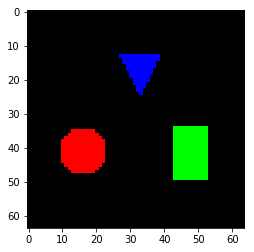

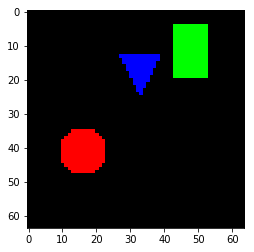

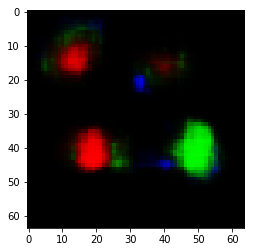

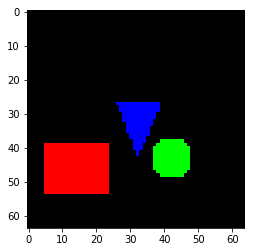

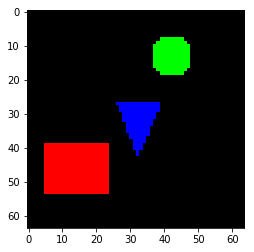

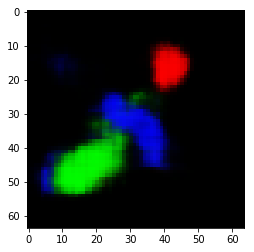

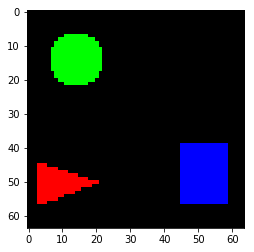

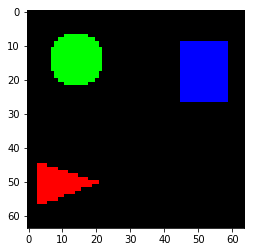

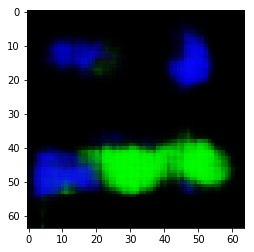

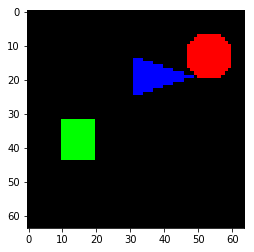

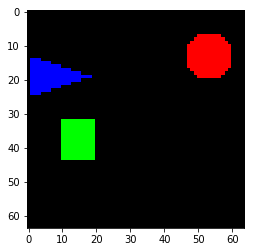

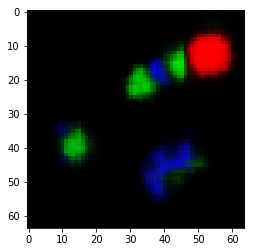

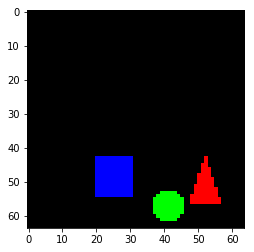

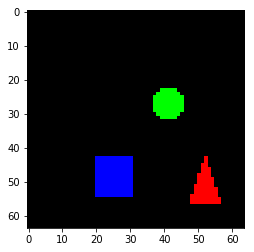

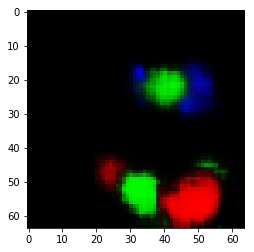

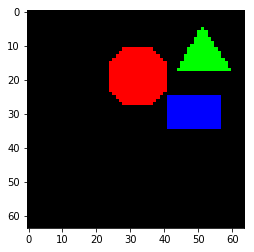

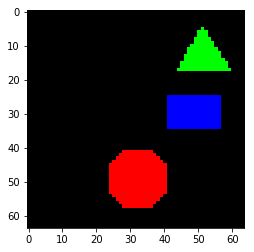

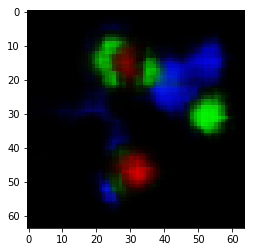

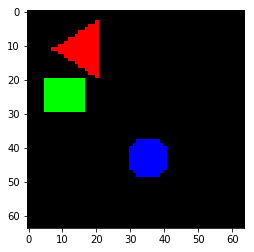

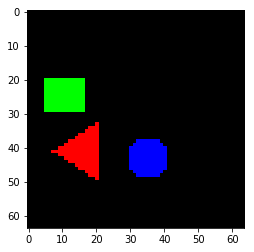

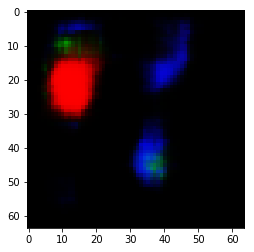

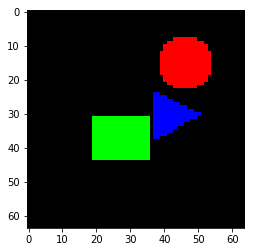

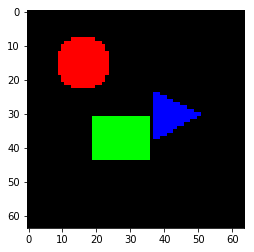

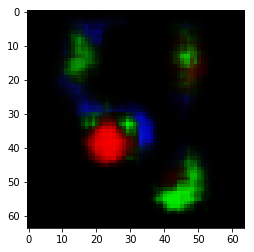

In [11]:

x_test = input_test
y_test = output_test
n = bs  # how many digits we will display
# plt.figure(figsize=(20, 4))


for i in range(n):
#     ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.array(x_test[i]*255, dtype=np.uint8))
    plt.show()
    plt.imshow(np.array(y_test[i]*255, dtype=np.uint8))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    plt.show()
    # display reconstruction
#     ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(np.array(decoded_imgs[i]*255, dtype=np.uint8))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    plt.show()

    
#plt.show()
plt.savefig('mnist_ae2.png')


In [12]:
total_parameters = 0
for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
#     print(shape)
#     print(len(shape))
    variable_parameters = 1
    for dim in shape:
#         print(dim)
        variable_parameters *= dim.value
#     print(variable_parameters)
    total_parameters += variable_parameters
print(total_parameters)

140043


In [13]:
saver = tf.train.Saver() 
saver.save(sess, 'train808NoSentModel/train808NoSent.chkp')

# Then you'll be able to access the model:

# sess = tf.Session()
# saver = tf.train.Saver()
# saver.restore(sess, 'filename.chkp')

'train808NoSentModel/train808NoSent.chkp'